In [1]:
import torch
import torch.nn.functional as F
import torchsde

from torchvision import datasets, transforms

import math
import numpy as np
import pandas as pd
from tqdm import tqdm

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import functorch

import matplotlib.pyplot as plt

import cfollmer.functional as functional
from cfollmer.objectives import relative_entropy_control_cost
from cfollmer.drifts import SimpleForwardNet, SimpleForwardNetBN, ResNetScoreNetwork
from cfollmer.sampler_utils import FollmerSDE

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class DNN(torch.nn.Module):
    
    def __init__(self, input_dim=1, output_dim=1):
        super(DNN, self).__init__()
        
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, output_dim)
        )
        
    def forward(self, x):
        return self.nn(x)

    
class LinModel(torch.nn.Module):
    
    def __init__(self, input_dim=1, output_dim=1):
        super(LinModel, self).__init__()
        
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 1),
        )
        
    def forward(self, x):
        return self.nn(x)

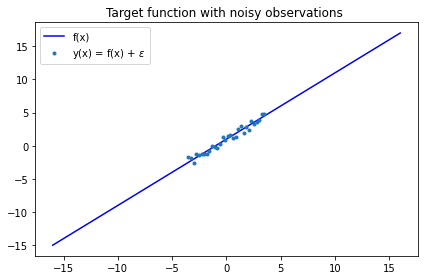

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"



def lin_reg_data_gen(dim, sigma_n, device, num_samps=30):

    w = np.ones((dim,1))
    b = 1

    func = lambda x: np.dot(x, w)  + 1

    # Test inputs
    num_test_samples = 30

    if dim == 1:
        X_test = np.linspace(-16, 16, num_samps).reshape(num_samps,1)
        X_train = np.linspace(-3.5, 3.5, num_samps).reshape(-1,1)
    else:
        X_test  = np.random.randn(num_samps, dim)
        X_train  = np.random.randn(num_samps, dim)

    # Noise free training inputs

    #f_train = np.cos(X_train) 
    f_train = func(X_train)

    # Noise-free training outputs
    #f = np.cos(X_test)
    f = func(X_test)
    y_test  = f

    # Noisy training Inputs with additive Gaussian noise (zero-mean, variance sigma_n)

    mu = np.zeros(X_train.size)
    epsilon = np.random.multivariate_normal(mu, sigma_n**2 * np.eye(X_train.size))

    # Noisy targets
    y_train = f_train + epsilon.reshape(X_train.size,1)
    
    return X_train, y_train, X_test, y_test, f

dim = dim_data = 1
sigma_n = 0.5

X_train, y_train, X_test, y_test, f = lin_reg_data_gen(dim,  sigma_n, device)

N_train , _ = X_train.shape
N_test , _ = X_test.shape

# if  dim == 1:
# Noisy observations
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(X_test[:,[0]], f, 'b', label = 'f(x)')
ax.plot(X_train[:,[0]], y_train,".",  label = 'y(x) = f(x) + $\epsilon$')
ax.legend(loc = 'upper left')
ax.set_title('Target function with noisy observations ')

plt.show()

In [41]:
X_train = torch.tensor(X_train, device=device, dtype=torch.float)
X_test = torch.tensor(X_test, device=device, dtype=torch.float)

y_train = torch.tensor(y_train, device=device, dtype=torch.float)
y_test = torch.tensor(y_test, device=device, dtype=torch.float)

In [96]:
model = LinModel().to(device)
func_model, params = functorch.make_functional(model)
size_list = functional.params_to_size_tuples(params)
dim = functional.get_number_of_params(size_list)

sigma2 = 1

def log_prior(params):
    return -torch.sum(params**2) / (2 * sigma2)

def log_likelihood(x, y, params):
    preds = func_model(functional.get_params_from_array(params, size_list), x)
    diff = preds - y
    
    return - torch.sum(diff**2) / (2 * sigma_n**2)

def log_likelihood_batch(x, y, params_batch):
    func = lambda params: log_likelihood(x, y, params)
    func = functorch.vmap(func)
    return func(params_batch)

def log_posterior(x, y, params):
    return log_prior(params) + (N_train / x.shape[0]) * log_likelihood(x, y, params)

def log_posterior_batch(x, y, params_batch):
    func = lambda params: log_posterior(x, y, params)
    func = functorch.vmap(func)
    return func(params_batch)

In [97]:
gamma = 0.1**2

n_steps = 300
data_batch_size = 50
param_batch_size = 32

In [98]:
def train(gamma, n_steps, data_batch_size, param_batch_size, dt=0.05, stl=False):
    sde = FollmerSDE(gamma, SimpleForwardNetBN(input_dim=dim, width=300)).to(device)
    optimizer = torch.optim.Adam(sde.parameters(), lr=1e-4)
    
    losses = []

    for _ in tqdm(range(n_steps)):
        perm = torch.randperm(N_train)
        x = X_train[perm[:data_batch_size], :]
        y = y_train[perm[:data_batch_size], :]

        optimizer.zero_grad()
        
        partial_log_p = lambda params_batch: log_posterior_batch(x, y, params_batch)
        
        loss = relative_entropy_control_cost(sde, partial_log_p, param_batch_size=param_batch_size, dt=dt, device=device)
        loss.backward()
        
        losses.append(loss.detach().cpu().numpy())
        optimizer.step()
        
        if stl: # double check theres no references left
            sde.drift_network_detatched.load_state_dict((sde.drift_network.state_dict()))
    
    losses = np.array(losses)
    
    return sde, losses

In [99]:
def predict(param_samples, x, y):
    with torch.no_grad():
        predict_func = lambda params : func_model(functional.get_params_from_array(params, size_list), x)
        predict_func = functorch.vmap(predict_func)

        preds = predict_func(param_samples)

        std, mean = torch.std_mean(preds, dim=0)
        mse = torch.mean((y_test - mean)**2)
        logp = torch.mean(log_likelihood_batch(x, y, param_samples))
        
    return std, mean, logp, mse

In [100]:
def plot_fit(mean, std, title="", fn=None):
    x = X_test.cpu().squeeze()
    std = std.cpu().squeeze()
    mean = mean.cpu().squeeze()
    
    plt.plot(x, mean)
    plt.fill_between(x, mean - 2 * std, mean + 2 * std, alpha=0.2)
    plt.plot(X_train.cpu(), y_train.cpu(), 'kP', ms = 9)
    plt.title(title)
    plt.legend(["mean prediction", "data", r"$\pm 2\sigma^2$"], loc="upper left")
    if fn is not None:
        plt.savefig(fn, bbox_inches="tight", dpi=600)
        plt.close()

In [391]:
sde, losses = train(gamma, n_steps, data_batch_size, param_batch_size)

  0%|          | 0/300 [00:00<?, ?it/s]/home/fav25/.conda/envs/functorch/lib/python3.9/site-packages/torch/nn/functional.py:2282: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::batch_norm. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /tmp/pip-req-build-jk216yxu/functorch/csrc/BatchedFallback.cpp:106.)
  return torch.batch_norm(
100%|██████████| 300/300 [00:14<00:00, 20.70it/s]


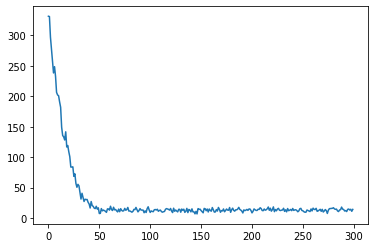

In [392]:
plt.plot(losses)

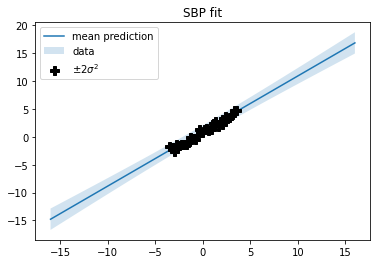

In [395]:
param_samples = sde.sample(100, dt=0.01, device=device)
std, mean, logp, mse = predict(param_samples, X_test, y_test)

std = torch.sqrt(std**2 + sigma_n**2)
plot_fit(mean, std, title="SBP fit", fn=None)
plt.show()
plot_fit(mean, std, title="SBP fit", fn="plots/step_func/sbp_fit.png")
# plt.show()

In [396]:
param_samples.std(dim=0), sfs_samps.std(dim=0)

(tensor([0.0507, 0.0888], device='cuda:0', grad_fn=<StdBackward0>),
 tensor([0.0420, 0.1071], device='cuda:0'))

In [381]:
class MCFollmerDrift:
    
    def __init__(self, log_posterior, X,y, dim, device, n_samp=100, gamma=torch.tensor(1), debug=False):
        self.log_posterior = log_posterior
        self.debug = debug
        self.log_posterior = log_posterior
        self.device = device
        self.X = X
        self.dim = dim
        self.y = y
        self.gamma = gamma
        self.n_samp = n_samp
        self.distrib = torch.distributions.multivariate_normal.MultivariateNormal(
            loc=torch.zeros(dim),
            covariance_matrix=torch.eye(dim) * torch.sqrt(gamma)
        )
        
    def g(self, thet):
        func = lambda params: self.log_posterior(self.X, self.y, params)
        func = functorch.vmap(func)
        lp = func(thet)
        reg = 0.5 * (thet**2).sum(dim=-1) / self.gamma
        
#             if torch.any(torch.isinf(torch.exp(lp + reg))):

        out = torch.exp(lp + reg)
        isnan = torch.isinf(torch.abs(out)) | torch.isnan(out)
        if self.debug and torch.any(isnan):
            import pdb; pdb.set_trace()
#         import pdb; pdb.set_trace()
        return out # nans exp(reg)

    def ln_g(self, thet):
        func = lambda params: self.log_posterior(self.X, self.y, params)
        func = functorch.vmap(func)
        lp = func(thet)
        reg = 0.5 * (thet**2).sum(dim=-1) / self.gamma
        
        out = lp + reg
        isnan = torch.isinf(torch.abs(out)) | torch.isnan(out)
        if self.debug and torch.any(isnan):
            import pdb; pdb.set_trace()
            
        return out # nans exp(reg)
        
    def mc_follmer_drift_(self, t, params, Z):
        # Using Stein Estimator for SFS drift

        g_YZt = self.g(params[None, ...] + torch.sqrt(1-t) * Z)
        num = (Z * g_YZt[..., None]).mean(dim=0)
        denom = torch.sqrt(1-t) * (g_YZt).mean(dim=0)
        
        out = num / denom[...,None]
        
        isnan = torch.isinf(torch.abs(out)) | torch.isnan(out)
        
        return out
    
    def mc_follmer_drift_stable(self, t, params, Z):
        # Using Stein Estimator for SFS drift
        N, d = Z.shape
        lnN = torch.log(torch.tensor(N)).to(self.device)
        
        ln_g_YZt = self.ln_g(params[None, ...] + torch.sqrt(1-t) * Z)
        
        Z_plus = torch.nn.functional.relu(Z)
        Z_minus = torch.nn.functional.relu(-Z)        
        
        ln_num_plus = torch.logsumexp(
            (torch.log(Z_plus) + ln_g_YZt[..., None]) - lnN,
            dim=0,
        )
        ln_num_minus = torch.logsumexp(
            (torch.log(Z_minus) + ln_g_YZt[..., None]) - lnN,
            dim=0
        )
#         num =  torch.exp(num_plus) - torch.exp(num_minus)
        
        ln_denom = torch.logsumexp(
            torch.log(torch.sqrt(1-t))  + (ln_g_YZt) - lnN,
            dim=0
        )
        
        out =  torch.exp(ln_num_plus-ln_denom) - torch.exp(ln_num_minus-ln_denom)
        
        
        isnan = torch.isinf(torch.abs(out)) | torch.isnan(out)
        
        return out 
    
    def mc_follmer_drift_debug(self, t, params):
        # Using Stein Estimator for SFS drift
        
        
        Z = self.distrib.rsample((self.n_samp,)).to(self.device)
        params = params[0]

        g_YZt = self.g(params[None, ...] + torch.sqrt(1-t) * Z)
        num = (Z * g_YZt[..., None]).mean(dim=0)
        denom = torch.sqrt(1-t) * (g_YZt).mean(dim=0)
        
        out = num / denom[...,None]
        
        isnan = torch.isinf(torch.abs(out)) | torch.isnan(out)
        
        if self.debug and torch.any(isnan):
            import pdb; pdb.set_trace()
        
        return out.reshape(1,-1)
    
    def mc_follmer_drift(self, t , params_batch):
        Z = self.distrib.rsample((params_batch.shape[0], self.n_samp)).to(self.device)
        
        func = lambda params, z: self.mc_follmer_drift_stable(t, params, z)
        func = functorch.vmap(func, in_dims=(0,0) )
        out = func(params_batch, Z)
#         import pdb; pdb.set_trace()
        return out

    

class MCFollmerSDE(torch.nn.Module):

    def __init__(self, gamma, dim, log_posterior, X_train, y_train, device, debug=False):
        super().__init__()

        self.noise_type = 'diagonal'
        self.sde_type = 'ito'
        self.gamma = gamma
        if debug:
            self.drift =  MCFollmerDrift(log_posterior, X_train, y_train, dim, device, gamma=gamma, debug=debug).mc_follmer_drift_debug
        else:
            self.drift =  MCFollmerDrift(log_posterior, X_train, y_train, dim, device, gamma=gamma).mc_follmer_drift
        self.dim = dim
        
    def f(self, t, y, detach=False):
        return self.drift(t, y)
        
    def g(self, t, y):
        return torch.sqrt(self.gamma )* torch.ones_like(y)

    def sample_trajectory(self, batch_size, dt=0.05, device=None):
        param_init = torch.zeros((batch_size, self.dim), device=device)

        n_steps = int(1.0 / dt)

        ts = torch.linspace(0, 1, n_steps, device=device)

        param_trajectory = torchsde.sdeint(self, param_init, ts, method="euler", dt=dt)

        return param_trajectory, ts

    def sample(self, batch_size, dt=0.05, device=None):
        return self.sample_trajectory(batch_size, dt=dt, device=device)[0] [-1]#[-1]
    

# mcfol = MCFollmerDrift(log_posterior, X_train, y_train, dim, device)
sde_sfs = MCFollmerSDE(torch.tensor(gamma), dim, log_posterior, X_train, y_train, device)

In [382]:
# sfs_samps

In [383]:
sfs_samps = sde_sfs.sample(130, dt=0.01, device=device)

/tmp/ipykernel_553292/3453989063.py:40: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::__or__.Tensor. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /tmp/pip-req-build-jk216yxu/functorch/csrc/BatchedFallback.cpp:106.)
  isnan = torch.isinf(torch.abs(out)) | torch.isnan(out)
/tmp/ipykernel_553292/3453989063.py:87: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::__or__.Tensor. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /tmp/pip-req-build-jk216yxu/functorch/csrc/BatchedFallback.cpp:106.)
  isnan = torch.isinf(torch.abs(out)) | torch.isnan(out)


In [384]:
sfs_samps

tensor([[1.0886, 1.0904],
        [1.0428, 0.8789],
        [1.0253, 0.9630],
        [1.1552, 1.0976],
        [1.1395, 0.8974],
        [1.0375, 0.6623],
        [1.0984, 0.8723],
        [1.0370, 0.8316],
        [1.0488, 0.9094],
        [1.1225, 0.8180],
        [1.0922, 1.0845],
        [1.0189, 0.9606],
        [1.0145, 0.7575],
        [1.0998, 0.9404],
        [1.0904, 0.8552],
        [1.0413, 1.0987],
        [1.0720, 0.9375],
        [0.9064, 0.9042],
        [1.0903, 0.9572],
        [1.1007, 0.8979],
        [1.1088, 1.0463],
        [1.1166, 1.1240],
        [1.0889, 0.8988],
        [1.1064, 0.9044],
        [1.0654, 0.9966],
        [1.0704, 0.8023],
        [1.0343, 0.8912],
        [1.0906, 0.8106],
        [1.0702, 0.8323],
        [0.9637, 0.9828],
        [1.0629, 0.8087],
        [1.1253, 0.6813],
        [1.0729, 0.9013],
        [1.0702, 0.9110],
        [1.0189, 0.9728],
        [1.0423, 0.9201],
        [1.0594, 0.6647],
        [1.1070, 1.0463],
        [1.1

In [385]:
(~torch.isnan(sfs_samps).sum(dim=1).bool()).sum()

tensor(130, device='cuda:0')

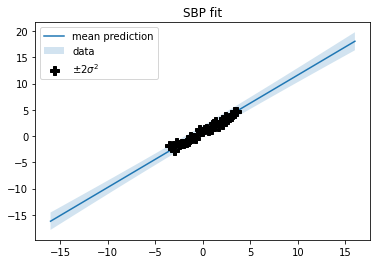

In [397]:
sfs_samps = sfs_samps[~torch.isnan(sfs_samps).sum(dim=1).bool()]

std_sfs, mean_sfs, logp_sfs, mse_sfs = predict(sfs_samps, X_test, y_test)

std_sfs = torch.sqrt(std_sfs**2 + sigma_n**2)
plot_fit(mean_sfs, std_sfs, title="SBP fit", fn=None)
plt.show()
plot_fit(mean_sfs, std_sfs, title="SBP fit", fn="plots/step_func/sbp_sfs_mc_fit.png")

In [111]:
def pred_true_std(X_train, X_test, sigma_n, sigma2, dim):
    # https://github.com/probml/pml-book/releases/latest/download/book1.pdf
    # See Eq 11.124 in the above link page 430 on pdf viewer (page 400 on page number in pdf)

    X_trainnp = X_train.cpu().detach().numpy()
    n_, d = X_trainnp.shape

    X_trainnp = np.concatenate((X_trainnp, np.ones((n_, 1))), axis=1)

    X_testnp = X_test.cpu().detach().numpy()
    n_, d = X_testnp.shape

    X_testnp = np.concatenate((X_testnp, np.ones((n_, 1))), axis=1)


    print(X_trainnp.shape)

    Sigma_post = sigma_n**2 * np.linalg.inv(sigma_n**2 *  np.eye(dim) / sigma2 + np.dot(X_trainnp.T,X_trainnp))
    
    sigma_pred = []
    for i in range(n_):
        sigma_pred += [np.dot(X_testnp[i,:].dot(Sigma_post), X_testnp[i,:]) + sigma_n**2 ]

    std_true = np.sqrt(sigma_pred)
    return std_true

std_true = pred_true_std(X_train, X_test, sigma_n,  sigma2, dim)

(30, 2)


In [112]:
std_true.shape

(30,)

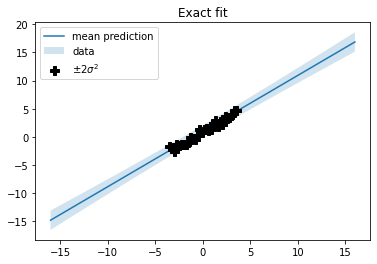

In [113]:
param_samples = sde.sample(100, dt=0.01, device=device)

plot_fit(mean, torch.tensor(std_true), title="Exact fit", fn=None)
plt.show()
# plot_fit(mean, std, title="SBP fit", fn="plots/step_func/sbp_fit.png")

In [20]:
logp, mse

(tensor(-73.4771, device='cuda:0'), tensor(0.0039, device='cuda:0'))

In [ ]:
n_runs = 5

sbp_mse = []
sbp_logp = []

for i in range(n_runs):
    sde, losses = train(gamma, n_steps, data_batch_size, param_batch_size)
    
    with torch.no_grad():
        param_samples = sde.sample(100, dt=0.01, device=device)
    
    
    
    std, mean, logp, mse = predict(param_samples, X_test, y_test)
    
    std = torch.sqrt(std**2 + sigma_n**2)
    plot_fit(mean, std, title="SBP fit", fn=None)
    plt.show()
    
    plot_fit(mean, std, title="SBP fit #{}".format(i+1), fn="plots/step_func/sbp_fit_#{:d}.png".format(i+1))
    
    sbp_mse.append(mse.cpu().numpy())
    sbp_logp.append(logp.cpu().numpy())
    
sbp_mse = np.array(sbp_mse)
sbp_logp = np.array(sbp_logp)

  0%|          | 0/300 [00:00<?, ?it/s]/home/fav25/.conda/envs/functorch/lib/python3.9/site-packages/torch/nn/functional.py:2282: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::batch_norm. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /tmp/pip-req-build-jk216yxu/functorch/csrc/BatchedFallback.cpp:106.)
  return torch.batch_norm(
  0%|          | 0/300 [00:00<?, ?it/s]/home/fav25/.conda/envs/functorch/lib/python3.9/site-packages/torch/nn/functional.py:2282: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::batch_norm. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /tmp/pip-req-build-jk216yxu/functorch/csrc/BatchedFallback.cpp:106.)
  return torch.batch_norm(
  0%|          | 0/300 [00:00<?, ?it/s]/home/fav25/.conda/envs/functorch/lib/python3.9/site-packages/t

In [ ]:
@torch.enable_grad()
def gradient(x, y, params):
    params_ = params.clone().requires_grad_(True)
    loss = log_posterior(x, y, params_)
    grad, = torch.autograd.grad(loss, params_)
    return loss.detach().cpu().numpy(), grad

In [ ]:
def step_size(n):
    return 1e-4/ (1 + n)**0.1

In [ ]:
def sgld(n_steps, last_n, data_batch_size):
    losses = []
    param_samples = []
    
    params = torch.zeros(dim).float().to(device)
    
    for step in tqdm(range(n_steps)):
        perm = torch.randperm(N_train)
        x = X_train[perm[:data_batch_size], :]
        y = y_train[perm[:data_batch_size], :]

        eps = step_size(step)
        loss, grad = gradient(x, y, params)
        params = params + 0.5 * eps * grad + np.sqrt(eps) * torch.randn_like(params)
        
        if n_steps <= step + last_n:
            param_samples.append(params)
        losses.append(loss)
        
    param_samples = torch.stack(param_samples)
    
    return param_samples, losses

In [ ]:
param_samples, losses = sgld(10000, 2000, data_batch_size)

In [ ]:
plt.plot(losses)

In [ ]:
std, mean, logp, mse = predict(param_samples[:100], X_test, y_test)

std = torch.sqrt(std**2 + sigma_n**2)


In [25]:
plot_fit(mean, std, title="SBP fit", fn=None)
plt.show()

plot_fit(mean, std, title="SGLD fit", fn="plots/step_func/sgld_fit.png")

In [27]:
n_runs = 5
n_steps = 10000

sgld_mse = []
sgld_logp = []

for i in range(n_runs):
    param_samples, losses = sgld(n_steps, 1000, data_batch_size)
    
    std, mean, logp, mse = predict(param_samples[:100], X_test, y_test)
    plot_fit(mean, std, title="SGLD fit #{} (100 samples)".format(i+1), fn="plots/step_func/sgld_fit_#{:d}_100.png".format(i+1))
    
    std, mean, _, _ = predict(param_samples[:500], X_test, y_test)
    plot_fit(mean, std, title="SGLD fit #{} (500 samples)".format(i+1), fn="plots/step_func/sgld_fit_#{:d}_500.png".format(i+1))
    
    std, mean, _, _ = predict(param_samples, X_test, y_test)
    plot_fit(mean, std, title="SGLD fit #{} (1000 samples)".format(i+1), fn="plots/step_func/sgld_fit_#{:d}_1000.png".format(i+1))
    
    sgld_mse.append(mse.cpu().numpy())
    sgld_logp.append(logp.cpu().numpy())
    
sgld_mse = np.array(sgld_mse)
sgld_logp = np.array(sgld_logp)

100%|████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1284.46it/s]


In [29]:
SBP_df = pd.DataFrame({"mse": sbp_mse, "logp": sbp_logp})
SGLD_df = pd.DataFrame({"mse": sgld_mse, "logp": sgld_logp})

In [30]:
SBP_df

,mse,logp
0,0.001964,-57.789295
1,0.002125,-59.463318
2,0.002607,-56.198963
3,0.004290,-65.259750
4,0.003424,-76.526329


In [31]:
SBP_df.describe()

,mse,logp
count,5.000000,5.000000
mean,0.002882,-63.047527
std,0.000971,8.276026
min,0.001964,-76.526329
25%,0.002125,-65.259750
50%,0.002607,-59.463318
75%,0.003424,-57.789295
max,0.004290,-56.198963


In [32]:
SGLD_df

,mse,logp
0,0.206835,-1820.782104
1,0.105824,-897.239014
2,0.379812,-2585.553467
3,0.155833,-1200.368042
4,0.039080,-443.960571


In [33]:
SGLD_df.describe()

,mse,logp
count,5.000000,5.000000
mean,0.177477,-1389.580566
std,0.128994,834.967773
min,0.039080,-2585.553467
25%,0.105824,-1820.782104
50%,0.155833,-1200.368042
75%,0.206835,-897.239014
max,0.379812,-443.960571
